### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
mixture_path = '../../data/saccharose_hydrolysis/sucrose_better_baseline.csv'

reagents_names = ['saccharose', 'alpha-glucose','beta-glucose', 'fructose']

mixture_separator = '\t'

data_path = '../../data/saccharose_hydrolysis/'

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_path, sep = mixture_separator).iloc[:,:-1]

In [6]:
mixture_time_data

,Unnamed: 0,1\nSTANDARD_PROTON_PARAMETERS\n_1,2\nSTANDARD_PROTON_PARAMETERS\n_2,3\nSTANDARD_PROTON_PARAMETERS\n_3,4\nSTANDARD_PROTON_PARAMETERS\n_4,5\nSTANDARD_PROTON_PARAMETERS\n_5,6\nSTANDARD_PROTON_PARAMETERS\n_6,7\nSTANDARD_PROTON_PARAMETERS\n_7,8\nSTANDARD_PROTON_PARAMETERS\n_8,9\nSTANDARD_PROTON_PARAMETERS\n_9,...,1014\nSTANDARD_PROTON_PARAMETERS\n_1014,1015\nSTANDARD_PROTON_PARAMETERS\n_1015,1016\nSTANDARD_PROTON_PARAMETERS\n_1016,1017\nSTANDARD_PROTON_PARAMETERS\n_1017,1018\nSTANDARD_PROTON_PARAMETERS\n_1018,1019\nSTANDARD_PROTON_PARAMETERS\n_1019,1020\nSTANDARD_PROTON_PARAMETERS\n_1020,1021\nSTANDARD_PROTON_PARAMETERS\n_1021,1022\nSTANDARD_PROTON_PARAMETERS\n_1022,1023\nSTANDARD_PROTON_PARAMETERS\n_1023
0,1.73276,-0.000185,-0.000130,0.000014,0.000123,-0.000130,0.000011,-0.000212,-0.000035,0.000120,...,0.000210,0.000002,0.000111,-0.000213,-0.000091,-0.000041,-0.000011,-0.000117,-0.000013,-0.000032
1,1.73288,-0.000053,-0.000033,-0.000010,0.000072,-0.000156,0.000197,-0.000266,0.000083,0.000076,...,0.000150,-0.000101,0.000066,-0.000128,0.000021,-0.000066,0.000155,-0.000123,-0.000021,0.000015
2,1.73300,0.000079,0.000063,-0.000034,0.000021,-0.000182,0.000097,-0.000026,0.000200,0.000032,...,0.000089,-0.000204,0.000021,-0.000043,0.000132,-0.000092,0.000152,0.000039,-0.000029,0.000062
3,1.73312,-0.000004,0.000105,-0.000062,-0.000008,-0.000032,-0.000095,0.000158,0.000279,0.000121,...,0.000080,-0.000201,0.000022,-0.000048,0.000082,-0.000165,0.000034,0.000029,0.000127,-0.000042
4,1.73324,-0.000087,-0.000033,-0.000090,-0.000037,0.000117,-0.000117,0.000047,0.000065,0.000210,...,0.000072,-0.000031,0.000024,-0.000053,0.000033,-0.000068,-0.000084,-0.000148,0.000282,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31840,5.60530,0.000147,-0.000013,0.000198,0.000101,-0.000114,-0.000034,0.000071,-0.000128,-0.000127,...,-0.000033,0.000249,0.000005,-0.000113,-0.000101,-0.000092,0.000139,0.000171,0.000070,0.000068
31841,5.60542,0.000142,-0.000034,0.000121,-0.000041,-0.000059,-0.000040,0.000048,-0.000066,-0.000028,...,0.000017,0.000182,-0.000118,-0.000060,-0.000038,0.000018,0.000243,0.000030,0.000090,0.000224
31842,5.60554,0.000137,-0.000056,0.000044,-0.000006,-0.000003,-0.000047,-0.000152,-0.000004,0.000071,...,0.000066,0.000116,-0.000241,-0.000008,0.000025,0.000127,0.000178,0.000055,0.000109,0.000106
31843,5.60566,-0.000071,-0.000094,-0.000019,0.000099,0.000012,-0.000102,-0.000286,0.000009,0.000147,...,0.000016,-0.000062,-0.000102,0.000072,-0.000024,0.000178,0.000059,0.000068,0.000111,-0.000172


In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


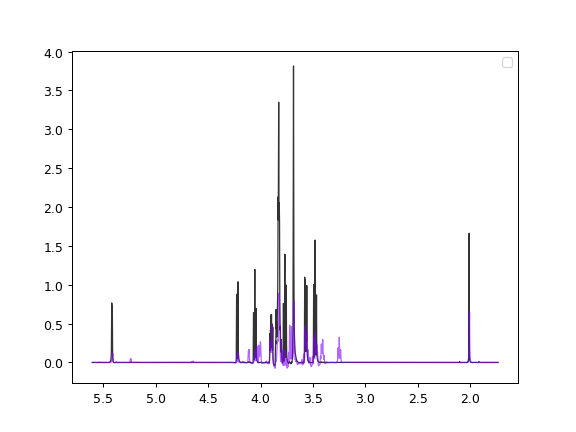

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all([load_spectrum(mixture_time_data, 1),
                     load_spectrum(mixture_time_data, 1000)], profile=True)

#### Reagents

In [12]:
# saccharose: (5.246521+0.2, 5.185803+0.2)
# alpha-glucose: (5.056501+0.2, 5.013715+0.2)
# beta-glucose: (4.465992+0.2, 4.419116+0.2)
# fructose: (3.805767+0.2, 3.776692+0.2)

In [13]:
mix1001 = pd.DataFrame(load_spectrum(mixture_time_data, 1001).confs)

reagent0 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>5.185803+0.2 and x<5.246521+0.2))]

reagent1 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>5.013715+0.2 and x<5.056501+0.2))]

reagent2 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>4.419116+0.2 and x<4.465992+0.2))]

reagent3 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>3.776692+0.2 and x<3.805767+0.2))]

reagents = [reagent0, reagent1, reagent2, reagent3]
reagents_sp = []

for reagent in reagents:
    ppm = reagent.iloc[:,0]
    ints = reagent.iloc[:,1]
    reagents_sp.append(NMRSpectrum(confs = list(zip(ppm, ints))))

for sp in reagents_sp:
    sp.trim_negative_intensities()
    sp.normalize()

<IPython.core.display.Javascript object>


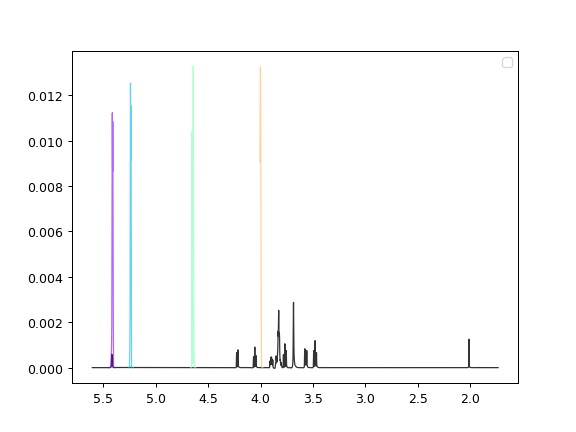

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [14]:
mix_to_plot = load_spectrum(mixture_time_data, 1)
mix_to_plot.normalize()

plt.gca().invert_xaxis()
NMRSpectrum.plot_all([mix_to_plot] + reagents_sp, profile=True)

### Mixture

In [15]:
mixture_time_data = mixture_time_data[mixture_time_data['ppm'].apply(lambda x: 
                                                                        (x>5.185803+0.2 and x<5.246521+0.2) or
                                                                        (x>5.013715+0.2 and x<5.056501+0.2) or 
                                                                        (x>4.419116+0.2 and x<4.465992+0.2) or
                                                                        (x>3.776692+0.2 and x<3.805767+0.2)
                                                                    )]

In [16]:
#baseline correction
# for colname in ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]:
#     mixture_time_data[colname] = mixture_time_data[colname].apply(lambda x: x-0.0395)

<IPython.core.display.Javascript object>


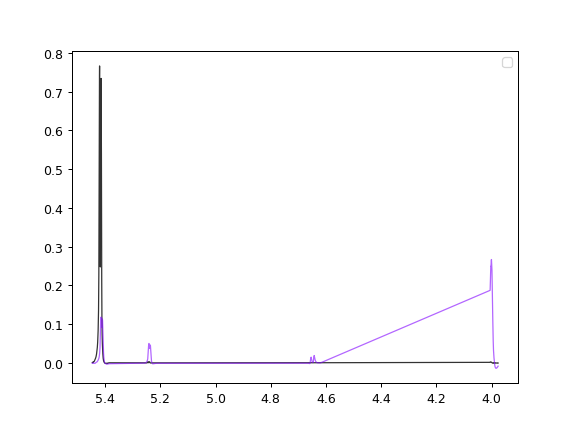

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all([load_spectrum(mixture_time_data, 1),
                     load_spectrum(mixture_time_data, 1000)], profile=True)

### Figures

<IPython.core.display.Javascript object>


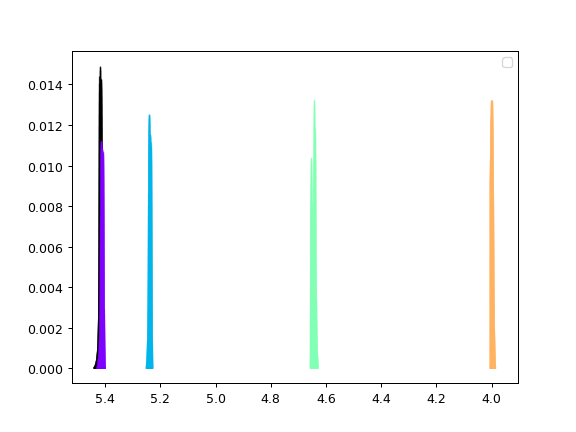

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [18]:
mix_to_plot = load_spectrum(mixture_time_data, 1)
mix_to_plot.trim_negative_intensities()
mix_to_plot.normalize()

plt.gca().invert_xaxis()
NMRSpectrum.plot_all([mix_to_plot] + reagents_sp, profile=False)

### Saving preprocessed spectra

In [19]:
np.savetxt(data_path + 'preprocessed_saccharose.csv', reagent0, delimiter = '\t')
np.savetxt(data_path + 'preprocessed_alpha_glucose.csv', reagent1, delimiter = '\t')
np.savetxt(data_path + 'preprocessed_beta_glucose.csv', reagent2, delimiter = '\t')
np.savetxt(data_path + 'preprocessed_fructose.csv', reagent3, delimiter = '\t')

In [20]:
np.savetxt(data_path + 'preprocessed_mixture.csv', mixture_time_data, delimiter = '\t')